<h2>Лабораторная работа 2</h2>

Цель - познакомиться с методом кластеризации K-mean с помощью пакета sklearn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats

df = pd.read_csv('./BankNoteAuthentication.csv')
print("Первоначальный размер датасета:", df.shape)

Первоначальный размер датасета: (1372, 5)


<h3>1. Добавляем новый аттрибут в датасет.</h3>

Создадим новый признак - комбинированную меру "сложности" банкноты

In [2]:
df['complexity_index'] = (df['variance']**2 + df['skewness']**2 + df['curtosis']**2)**0.5

print("\nДатасет с новым атрибутом 'complexity_index':")
print(df.head())


Датасет с новым атрибутом 'complexity_index':
   variance  skewness  curtosis  entropy  class  complexity_index
0   3.62160    8.6661   -2.8073 -0.44699      0          9.802969
1   4.54590    8.1674   -2.4586 -1.46210      0          9.665213
2   3.86600   -2.6383    1.9242  0.10645      0          5.060546
3   3.45660    9.5228   -4.0112 -3.59440      0         10.895941
4   0.32924   -4.4552    4.5718 -0.98880      0          6.392070


<h3>2. "Причесываем" датасет</h3>

In [3]:
print(f"Размер до очистки: {df.shape}")

# Проверка на пропущенные значения
print("\nПропущенные значения (до):")
print(df.isnull().sum())

# Проверка на дубликаты
duplicates_count = df.duplicated().sum()
print(f'\nНайдено дубликатов: {duplicates_count}')
if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Дубликаты удалены. получившийся размер: {df.shape}")

# Обработка выбросов с помощью z-score
z_scores = stats.zscore(df[['variance', 'skewness', 'curtosis', 'entropy']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

print(f"Размер после удаления выбросов: {df.shape}")
df.reset_index(drop=True, inplace=True)

Размер до очистки: (1372, 6)

Пропущенные значения (до):
variance            0
skewness            0
curtosis            0
entropy             0
class               0
complexity_index    0
dtype: int64

Найдено дубликатов: 24
Дубликаты удалены. получившийся размер: (1348, 6)
Размер после удаления выбросов: (1314, 6)


<h3>3. Построить графики зависимости (plt.scatter), описать кластеры.</h3>

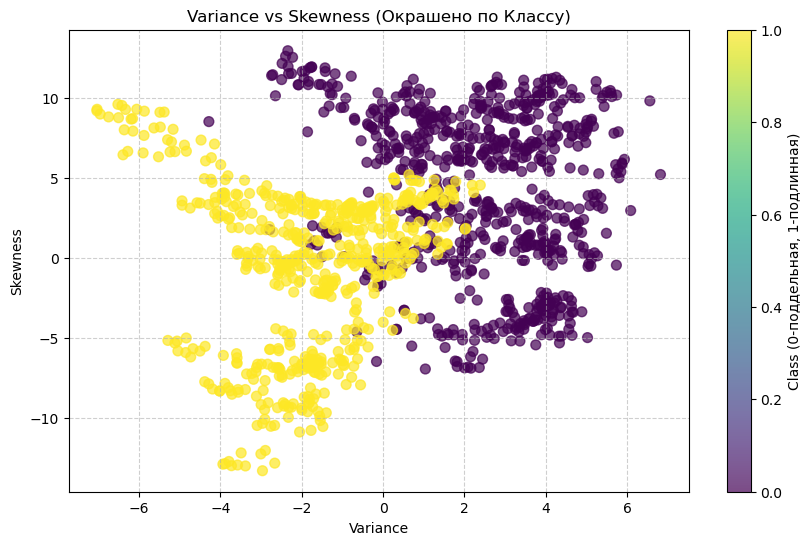

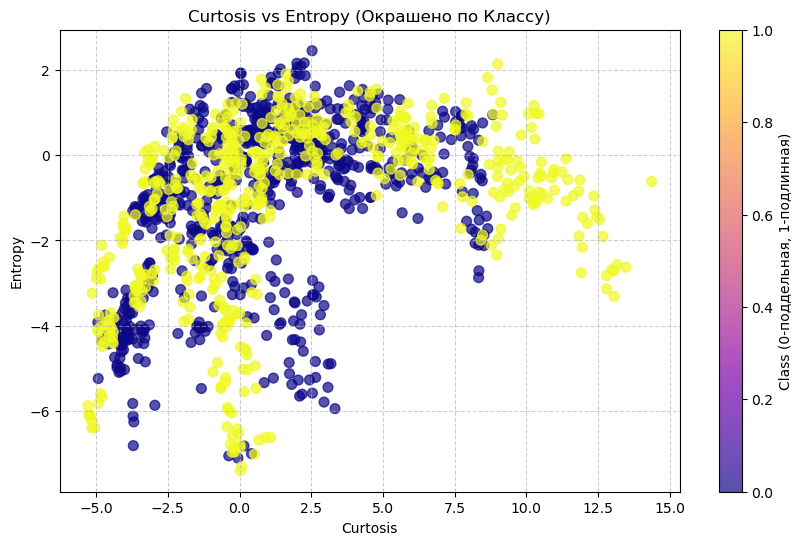

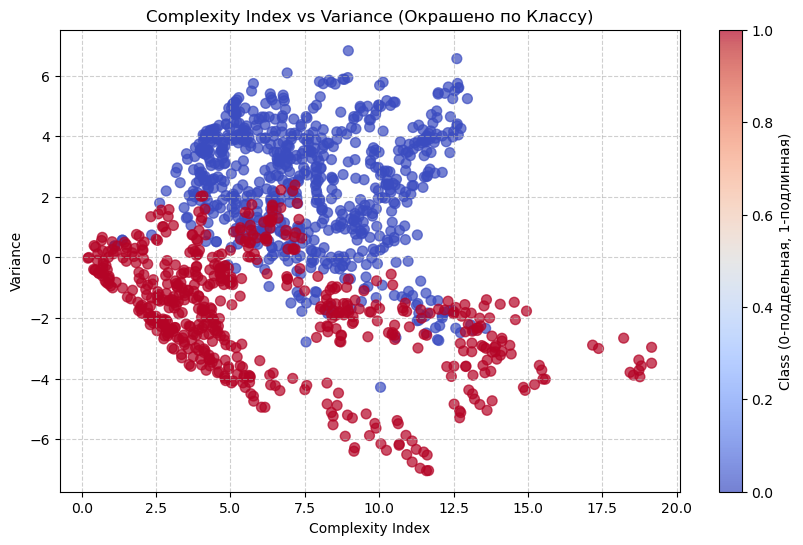

In [4]:
# --- 1. Variance vs. Skewness ---
plt.figure(figsize=(10, 6))
scatter1 = plt.scatter(df['variance'], df['skewness'], 
                       c=df['class'], cmap='viridis', alpha=0.7, s=50)
plt.title('Variance vs Skewness (Окрашено по Классу)')
plt.xlabel('Variance')
plt.ylabel('Skewness')
plt.colorbar(scatter1, label='Class (0-поддельная, 1-подлинная)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 2. Curtosis vs. Entropy ---
plt.figure(figsize=(10, 6))
scatter2 = plt.scatter(df['curtosis'], df['entropy'], 
                       c=df['class'], cmap='plasma', alpha=0.7, s=50)
plt.title('Curtosis vs Entropy (Окрашено по Классу)')
plt.xlabel('Curtosis')
plt.ylabel('Entropy')
plt.colorbar(scatter2, label='Class (0-поддельная, 1-подлинная)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 3. Complexity Index vs. Variance ---
plt.figure(figsize=(10, 6))
scatter3 = plt.scatter(df['complexity_index'], df['variance'], 
                       c=df['class'], cmap='coolwarm', alpha=0.7, s=50)
plt.title('Complexity Index vs Variance (Окрашено по Классу)')
plt.xlabel('Complexity Index')
plt.ylabel('Variance')
plt.colorbar(scatter3, label='Class (0-поддельная, 1-подлинная)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Variance vs Skewness

Здесь классы разделяются лучше всего.
Класс 0 — в области положительной variance, класс 1 — в области отрицательной.
Перекрытие минимальное → отличная пара признаков для кластеризации.

---

## Kurtosis vs Entropy

Разделение слабее.
Класс 1 занимает почти всё пространство, класс 0 чаще при низкой entropy.
Кластеры заметно пересекаются → умеренная пригодность.

---

## Complexity Index vs Variance

Класс 1 — при меньшем Complexity Index и большей variance;
Класс 0 — при большем Complexity Index и отрицательной variance.
Разделение есть, но с перекрытием → подходит, но хуже первой пары.

---

### Итог:

Самая перспективная пара признаков — Variance vs Skewness.

<h3>4. Применить метод KMeans.</h3>

Возьмем один из предложенных датасетов(Mall customers)

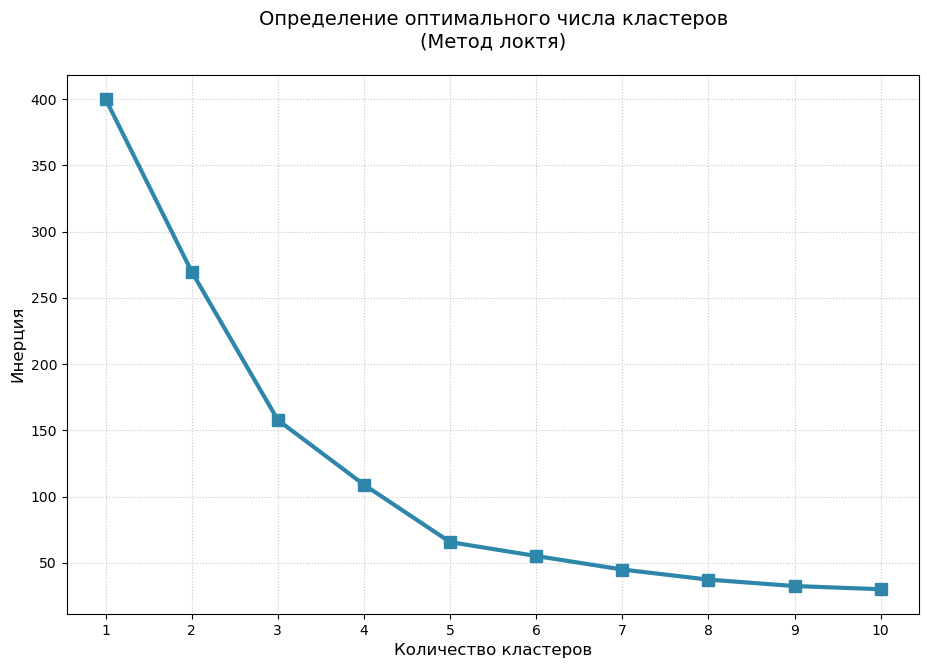

In [5]:
df = pd.read_csv('Mall_Customers.csv')

# Выбор признаков для кластеризации
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Поиск оптимального K по методу локтя ---
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_elbow.fit(X_scaled)
    inertia.append(kmeans_elbow.inertia_)

plt.figure(figsize=(11, 7))
plt.plot(k_range, inertia, marker='s', linewidth=3, markersize=8, color='#2E86AB')
plt.title('Определение оптимального числа кластеров\n(Метод локтя)', fontsize=14, pad=20)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Инерция', fontsize=12)
plt.xticks(k_range)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

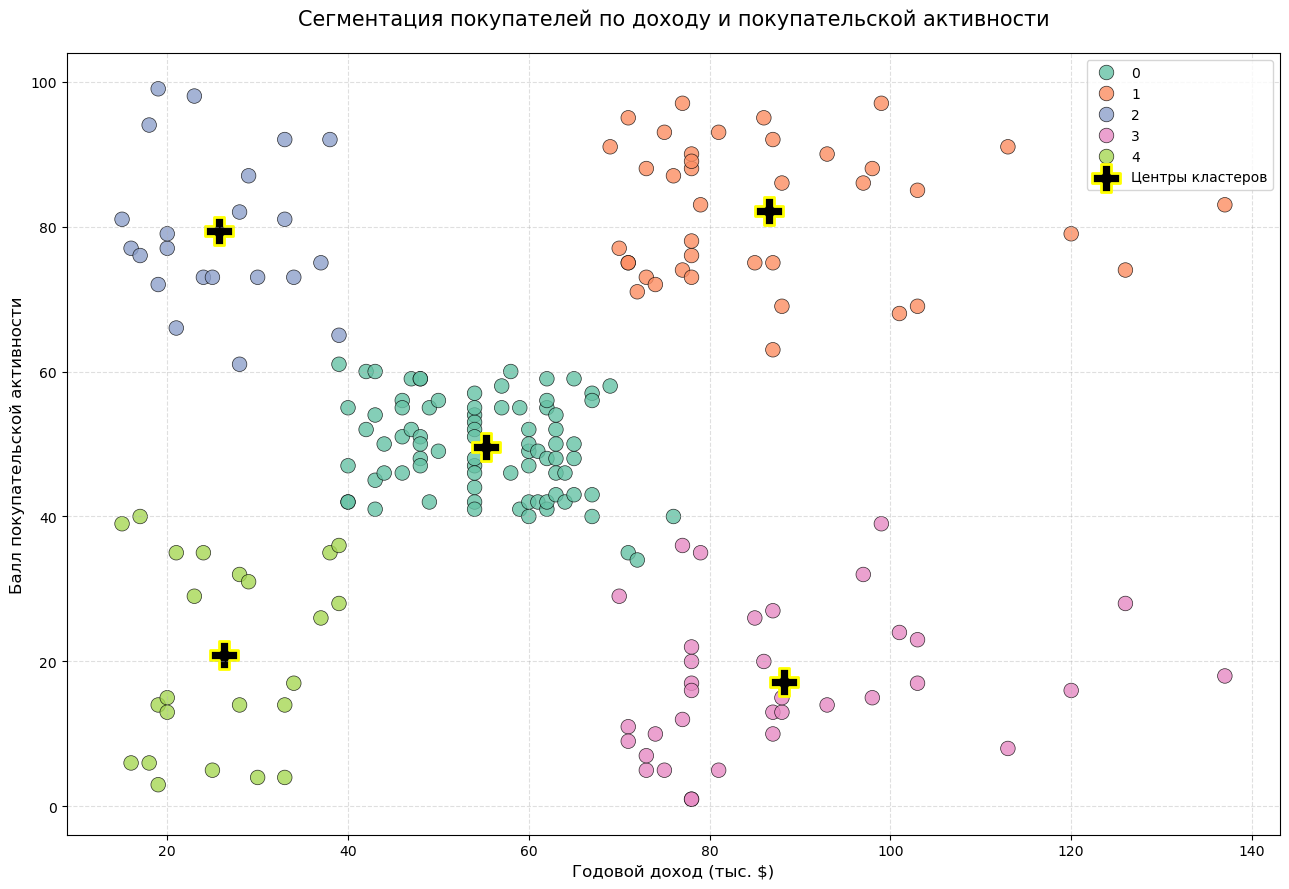

In [6]:
# --- Применение K-Means с k=5 ---

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

df['Cluster'] = y_kmeans

# --- Визуализация кластеров ---
plt.figure(figsize=(13, 9))

sns.scatterplot(
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    hue='Cluster',
    data=df,
    palette='Set2', 
    s=110,          
    alpha=0.8,
    edgecolor='black', 
    linewidth=0.5,
    legend='full'
)

centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(
    centers[:, 0], centers[:, 1], 
    s=400,         
    c='black',      
    marker='P',  
    label='Центры кластеров',
    edgecolors='yellow',
    linewidth=2
)

plt.title('Сегментация покупателей по доходу и покупательской активности', 
          fontsize=15, pad=20)
plt.xlabel('Годовой доход (тыс. $)', fontsize=12)
plt.ylabel('Балл покупательской активности', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Выводы

Визуализация кластеров наглядно демонстрирует, что алгоритм K-Means успешно разделил клиентов на 5 четко выраженных и логически интерпретируемых сегментов:

**Сегмент 0: "Экономные с высоким доходом"**
Характеристика: Высокий годовой доход при низком уровне трат.
Интерпретация: Состоятельные клиенты, демонстрирующие сдержанное покупательское поведение. Требуют индивидуального подхода для раскрытия потенциала.

**Сегмент 1: "Стабильные покупатели"**  
Характеристика: Средние показатели дохода и покупательской активности.
Интерпретация: Надежная клиентская база, формирующая основу бизнеса. Важная группа для поддержания стабильных продаж.

**Сегмент 2: "Бюджетные потребители"**
Характеристика: Низкий доход в сочетании с минимальными тратами.
Интерпретация: Ценово-ориентированные клиенты, чувствительные к акциям и специальным предложениям.

**Сегмент 3: "Активные покупатели с ограниченным бюджетом"**
Характеристика: Невысокий доход при высокой покупательской активности.
Интерпретация: Энтузиасты, возможно молодежь, готовые тратить значительную часть дохода. Перспективны для программ лояльности.

**Сегмент 4: "Премиальная категория"**
Характеристика: Высокий доход и максимальная покупательская активность.
Интерпретация: Ключевые клиенты, приносящие основную прибыль. Требуют эксклюзивного обслуживания и VIP-подхода.

Алгоритм K-Means подтвердил свою эффективность для задач рыночной сегментации. Без использования предварительных знаний о типах клиентов, метод автоматически выявил коммерчески значимые группы, позволяя разработать адресные маркетинговые стратегии для каждого сегмента. Полученные результаты имеют практическую ценность для оптимизации ассортимента, ценообразования и клиентского сервиса.